#Imports


In [505]:
!pip install ucimlrepo
!pip install gower
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import gower
from google.colab import files
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import pearsonr, fisher_exact, chi2_contingency
import matplotlib.pyplot as plt
from itertools import combinations

# Helper Functions

## Plot Combined ROC

In [506]:
def plot_combined_roc(y_test, y_prob_knn, y_prob_dt):
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn[:, 1])
    roc_auc_knn = auc(fpr_knn, tpr_knn)

    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt[:, 1])
    roc_auc_dt = auc(fpr_dt, tpr_dt)

    print(f"KNN Test AUROC: {roc_auc_knn:.4f}")
    print(f"Decision Tree Test AUROC: {roc_auc_dt:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUROC = {roc_auc_knn:.4f})", color='blue', lw=2)
    plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUROC = {roc_auc_dt:.4f})", color='green', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison: KNN vs Decision Tree")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

## Cross Validation

In [507]:
#         CROSS VALIDATION FUNCTIONS

# cross validation function used for knn
def cross_validate_knn(model, x, y, kf):
    # y values
    y_true_all = []
    y_pred_all = []

    # iterate through folds
    for train_index, test_index in kf.split(x):
        # split x and y data into training and validation sets
        x_train, x_val = x[train_index], x[test_index]
        y_train, y_val = y[train_index], y[test_index]

        # fit model on training data
        model.fit(x_train, y_train)
        # predict on validation
        y_prob, _ = model.predict(x_val)

        # get y values
        y_pred_all.extend(y_prob[:, 1])
        y_true_all.extend(y_val)

    # return y values
    return np.array(y_true_all), np.array(y_pred_all)

## Pearson's Correlation Correlation Function

In [508]:
#         PEARSON'S CORRELATION FUNCTION
def pearson_r(x, y):
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

## BestModel

In [509]:
# best model class used to find the best model using knn or dt based on auroc score
class BestModel:
    def __init__(self):
        self.best_model = None
        self.best_score = -1
        self.best_params = {}

    def update(self, model, score, params):
        if score > self.best_score:
            self.best_model = model
            self.best_score = score
            self.best_params = params

    def get_best(self):
        return self.best_model, self.best_score, self.best_params

# Task 1: Acquire, Preprocess, And Analyze The Data

## Loading Datasets And Removing NA's / Useless Columns

In [510]:
#         UPLOADING DATA & REMOVING NULL/USELESS FEATURES

# HEART DATA SET
heart_disease = fetch_ucirepo(id=45)
# set x to predictor variables
X = heart_disease.data.features
# set y to response variable
y = heart_disease.data.targets

# combine x and y
heart_df = pd.concat([X, y], axis=1)
# drop null values and reset indices
heart_df = heart_df.dropna().reset_index(drop=True)

print(heart_df)


# PENGUIN DATA SET
uploaded = files.upload()
penguin_df = pd.read_csv("penguins_size.csv")
print(penguin_df.head())

# drop island and sex
penguin_df = penguin_df.drop(columns=["island"])

contingency_table = pd.crosstab(penguin_df['sex'], penguin_df['species'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test p-value: {p:.4f}")
if p < 0.05:
    print("The 'sex' feature is significantly associated with 'species'.")
else:
    print("The 'sex' feature is not significantly associated with 'species'.")
    penguin_df = penguin_df.drop(columns=["sex"])

# drop null values
penguin_df = penguin_df.dropna()

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
292   57    0   4       140   241    0        0      123      1      0.2   
293   45    1   1       110   264    0        0      132      0      1.2   
294   68    1   4       144   193    1        0      141      0      3.4   
295   57    1   4       130   131    0        0      115      1      1.2   
296   57    0   2       130   236    0        2      174      0      0.0   

     slope   ca  thal  num  
0        3  0.0   6.0    0  
1        2  3.0   3.0    2  


Saving penguins_size.csv to penguins_size (15).csv
  species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
3  Adelie  Torgersen               NaN              NaN                NaN   
4  Adelie  Torgersen              36.7             19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE  
Chi-Square Test p-value: 0.7657
The 'sex' feature is not significantly associated with 'species'.


## Standardizing/Cleaning The Datasets

In [511]:
#         STANDARDIZE, CLEAN DATASETS, CALCULATE BASIC STATISTICS

scaler = StandardScaler()

# HEART DATA SET
print("Heart Data Set Basic Statistics:")
#print(heart_df.describe())

# response variable as 0 (has no heart disease) or 1 (has heart disease)
h_target_bin = np.where((heart_df["num"] >= 1) & (heart_df["num"] <= 4), 1, heart_df["num"])

# numerical and categorical features
h_num_features = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
h_cat_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

# scale numerical features
h_scaled = scaler.fit_transform(heart_df[h_num_features])
h_scaled_df = pd.DataFrame(h_scaled, columns=h_num_features, index=heart_df.index)
# combine scaled numerical features, categorical features, response variable
h_final_df = pd.concat([h_scaled_df["age"], heart_df["sex"], heart_df["cp"], h_scaled_df["trestbps"], h_scaled_df["chol"],
                        heart_df["fbs"], heart_df["restecg"], h_scaled_df["thalach"], heart_df["exang"], h_scaled_df["oldpeak"],
                        heart_df["slope"], h_scaled_df["ca"], heart_df["thal"], heart_df["num"]], axis=1)


hdf_target_pn = np.where((heart_df["num"] >= 1) & (heart_df["num"] <= 4), 1, heart_df["num"])

# Verify the results
print("\nBefore Standardization (only numerical data: age, trestbps, chol, thalach, oldpeak, ca):")
print("\nMean of non-scaled data:")
print(heart_df.drop(columns=h_cat_features).mean())
print("\nStd of non-scaled data:")
print(heart_df.drop(columns=h_cat_features).std())

print("\nAfter Standardization (only numerical data: age, trestbps, chol, thalach, oldpeak, ca):")
print("\nMean of scaled data (should be close to 0):")
print(h_scaled_df.mean())
print("\nStd of scaled data (should be close to 1):")
print(h_scaled_df.std())

print(h_final_df.head())


# PENGUIN DATA SET
print("\n\nPenguin Data Set Basic Statistics:")
#print(penguin_df.describe())

# numerical features
p_num_features = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]

# scale numerical feature
p_scaled = scaler.fit_transform(penguin_df[p_num_features])
p_scaled_df = pd.DataFrame(p_scaled, columns=p_num_features, index=penguin_df.index)
# combine scaled numerical features and response variable
p_final_df = pd.concat([p_scaled_df, penguin_df["species"]], axis=1)

print(p_final_df.describe())

# Verify the results
print("\nBefore Standardization:")
print("\nMean of non-scaled data:")
print(penguin_df.drop(columns=["species"]).mean())
print("\nStd of non-scaled data:")
print(penguin_df.drop(columns=["species"]).std())

print("\nAfter Standardization:")
print("\nMean of scaled data (should be close to 0):")
print(p_final_df.drop(columns=["species"]).mean())
print("\nStd of scaled data (should be close to 1):")
print(p_final_df.drop(columns=["species"]).std())

print(p_final_df.head())

Heart Data Set Basic Statistics:

Before Standardization (only numerical data: age, trestbps, chol, thalach, oldpeak, ca):

Mean of non-scaled data:
age          54.542088
trestbps    131.693603
chol        247.350168
thalach     149.599327
oldpeak       1.055556
ca            0.676768
num           0.946128
dtype: float64

Std of non-scaled data:
age          9.049736
trestbps    17.762806
chol        51.997583
thalach     22.941562
oldpeak      1.166123
ca           0.938965
num          1.234551
dtype: float64

After Standardization (only numerical data: age, trestbps, chol, thalach, oldpeak, ca):

Mean of scaled data (should be close to 0):
age        -1.226105e-16
trestbps    4.904420e-16
chol       -1.958777e-16
thalach     4.784800e-16
oldpeak     0.000000e+00
ca         -7.775299e-17
dtype: float64

Std of scaled data (should be close to 1):
age         1.001688
trestbps    1.001688
chol        1.001688
thalach     1.001688
oldpeak     1.001688
ca          1.001688
dtype: float

## Analyzing The Data

### Penguin Dataset

#### Penguin Statistics

In [512]:
species_means = p_final_df.groupby('species')[p_num_features].mean()

# initialize a dictionary to store squared differences
squared_diff_results = {}

for feature in p_num_features:
    squared_diff_results[feature] = {}
    for species1, species2 in combinations(species_means.index, 2):

        squared_diff = (species_means.loc[species1, feature] - species_means.loc[species2, feature]) ** 2
        squared_diff_results[feature][f"{species1} vs {species2}"] = squared_diff


squared_diff_df = pd.DataFrame(squared_diff_results)

# rank and sort
ranked_squared_diff = {}
for feature in squared_diff_df.columns:
    ranked_squared_diff[feature] = sorted(squared_diff_df[feature].items(), key=lambda x: x[1], reverse=True)

# print
print("\n=== Ranked Squared Differences Between Species for Each Feature ===")
for feature, rankings in ranked_squared_diff.items():
    print(f"\nFeature: {feature}")
    for rank, (pair, value) in enumerate(rankings, start=1):
        print(f"  Rank {rank}: {pair} - Squared Difference = {value:.4f}")


print("\n=== Mean Between Species for Each Feature ===")
print(p_final_df.describe())



=== Ranked Squared Differences Between Species for Each Feature ===

Feature: culmen_length_mm
  Rank 1: Adelie vs Chinstrap - Squared Difference = 3.3934
  Rank 2: Adelie vs Gentoo - Squared Difference = 2.5547
  Rank 3: Chinstrap vs Gentoo - Squared Difference = 0.0594

Feature: culmen_depth_mm
  Rank 1: Chinstrap vs Gentoo - Squared Difference = 3.0406
  Rank 2: Adelie vs Gentoo - Squared Difference = 2.9107
  Rank 3: Adelie vs Chinstrap - Squared Difference = 0.0014

Feature: flipper_length_mm
  Rank 1: Adelie vs Gentoo - Squared Difference = 3.7618
  Rank 2: Chinstrap vs Gentoo - Squared Difference = 2.3149
  Rank 3: Adelie vs Chinstrap - Squared Difference = 0.1748

Feature: body_mass_g
  Rank 1: Adelie vs Gentoo - Squared Difference = 2.9499
  Rank 2: Chinstrap vs Gentoo - Squared Difference = 2.8124
  Rank 3: Adelie vs Chinstrap - Squared Difference = 0.0016

=== Mean Between Species for Each Feature ===
       culmen_length_mm  culmen_depth_mm  flipper_length_mm   body_mass_g

### Heart Dataset

#### Heart Statistics

In [513]:
# separate positive and negative groups
positive_group = h_final_df[h_final_df['num'] > 0]
negative_group = h_final_df[h_final_df['num'] == 0]

# compute mean for each feature for positive and negative groups
mean_positive = positive_group[h_num_features].mean()
mean_negative = negative_group[h_num_features].mean()

# compute squared differences of group means
squared_diff_means = (mean_positive - mean_negative) ** 2

# rank features by squared differences
ranked_features = squared_diff_means.sort_values(ascending=False)

# display results
print("\n=== Squared Differences of Group Means (Ranked) ===")
print(ranked_features)

# identify top ranked features
print("\n=== Top Features Based on Squared Differences ===")
for feature, value in ranked_features.items():
    print(f"- {feature}: Squared Difference = {value:.4f}")

print("\n=== Mean of Each Feature for Positive and Negative Groups ===")
print(f"Positive Group Means:\n{mean_positive}")
print(f"Negative Group Means:\n{mean_negative}")


=== Squared Differences of Group Means (Ranked) ===
ca          0.863352
oldpeak     0.723620
thalach     0.722818
age         0.207497
trestbps    0.094805
chol        0.025938
dtype: float64

=== Top Features Based on Squared Differences ===
- ca: Squared Difference = 0.8634
- oldpeak: Squared Difference = 0.7236
- thalach: Squared Difference = 0.7228
- age: Squared Difference = 0.2075
- trestbps: Squared Difference = 0.0948
- chol: Squared Difference = 0.0259

=== Mean of Each Feature for Positive and Negative Groups ===
Positive Group Means:
age         0.245397
trestbps    0.165875
chol        0.086763
thalach    -0.458013
oldpeak     0.458267
ca          0.500562
dtype: float64
Negative Group Means:
age        -0.210121
trestbps   -0.142030
chol       -0.074291
thalach     0.392174
oldpeak    -0.392391
ca         -0.428606
dtype: float64


#### Using Pearson's Correlation

In [514]:
#         APPLY PEARSON'S CORRELATION ON NUMERICAL DATA

# assign pearson correlation thresholds
pearsons_corr_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# calculate pearsons correlation for each numerical predictor against response variable
pearsons_corr_coeffs = []
for feature in h_num_features:
    corr_val = pearson_r(h_final_df[feature], h_final_df["num"])
    pearsons_corr_coeffs.append(corr_val)


# create dataframe for feature and value of pearsons correlation value
pearsons_corr_df = pd.DataFrame({
    'Feature': h_num_features,
    'Correlation': pearsons_corr_coeffs
    }).sort_values(by='Correlation', ascending=False).reset_index(drop=True)
print("Pearson's Correlation:\n", pearsons_corr_df, "\n")

# create dataframe for feature and absolute value of pearsons correlation
abs_pearsons_corr_df = pearsons_corr_df.copy()
abs_pearsons_corr_df['Correlation'] = abs_pearsons_corr_df['Correlation'].abs()
abs_pearsons_corr_df.sort_values(by='Correlation', ascending=False, inplace=True)
abs_pearsons_corr_df.reset_index(drop=True)
print("Absolute Value of Pearson's Correlation:\n", abs_pearsons_corr_df, "\n")


# find numerical features based on our pearson correlation thresholds
print("Features per Pearsons' Correlation Threshold:")
features_per_pearson_threshold = {}

# iterate through pearson correlation thresholds
for threshold in pearsons_corr_thresholds:
    # select features that have a pearson correlation coefficient greater than the threshold
    selected_feats = abs_pearsons_corr_df[abs_pearsons_corr_df['Correlation'] > threshold]['Feature'].tolist()
    # get data of the selected features
    filtered_data = h_final_df[selected_feats]
    # add data of features if correlation coefficient of features is greater than threshold
    features_per_pearson_threshold[f"threshold_{threshold}"] = filtered_data

    print(f"Threshold = {threshold}", "|", f"Selected Numeric Features = {selected_feats}")

Pearson's Correlation:
     Feature  Correlation
0        ca     0.521178
1   oldpeak     0.501461
2       age     0.222156
3  trestbps     0.159620
4      chol     0.066448
5   thalach    -0.420639 

Absolute Value of Pearson's Correlation:
     Feature  Correlation
0        ca     0.521178
1   oldpeak     0.501461
5   thalach     0.420639
2       age     0.222156
3  trestbps     0.159620
4      chol     0.066448 

Features per Pearsons' Correlation Threshold:
Threshold = 0.0 | Selected Numeric Features = ['ca', 'oldpeak', 'thalach', 'age', 'trestbps', 'chol']
Threshold = 0.1 | Selected Numeric Features = ['ca', 'oldpeak', 'thalach', 'age', 'trestbps']
Threshold = 0.2 | Selected Numeric Features = ['ca', 'oldpeak', 'thalach', 'age']
Threshold = 0.3 | Selected Numeric Features = ['ca', 'oldpeak', 'thalach']
Threshold = 0.4 | Selected Numeric Features = ['ca', 'oldpeak', 'thalach']
Threshold = 0.5 | Selected Numeric Features = ['ca', 'oldpeak']
Threshold = 0.6 | Selected Numeric Feature

#### Using Fisher's Exact Test

In [515]:
#         APPLY FISHER'S EXACT TEST ON CATEGORICAL DATA

# initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
# get categorical features as numpy array
categorical_data = heart_df[h_cat_features].to_numpy()
# fit encoder to categorical features and transform to one-hot encoded format
cat_encoded = encoder.fit_transform(categorical_data)
# get feature names of one-hot encoded features
cat_feature_names = encoder.get_feature_names_out(h_cat_features)

# calculate fisher results
fisher_res = []
# iterate through all category feature names
for i, feature_name in enumerate(cat_feature_names):
    # 0/1 array for this one-hot category
    col_data = cat_encoded[:, i]

    #https://www.pathwaycommons.org/guide/primers/statistics/fishers_exact_test/
    # 1 in feature & 1 in target
    a = np.sum((col_data == 1) & (h_target_bin == 1))
    # 1 in feature & 0 in target
    b = np.sum((col_data == 1) & (h_target_bin == 0))
    # 0 in feature & 1 in target
    c = np.sum((col_data == 0) & (h_target_bin == 1))
    # 0 in feature & 0 in target
    d = np.sum((col_data == 0) & (h_target_bin == 0))

    # create 2x2 contingency table
    contingency_table = np.array([[a, b],
                                  [c, d]])

    # assess contingency table using fisher's exact test
    odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')

    # add feature name and corresponding p-value to fisher results
    fisher_res.append({
        'Feature': feature_name,
        'PValue': p_value
        })

# create dataframe of fisher results
fisher_df = pd.DataFrame(fisher_res).sort_values(by='PValue')
print("\nFisher's Exact Test (categorical):\n", fisher_df, "\n\n")

# fisher data set
fischer_ds = {}
# critical values
critical_values = [0.001, 0.01, 0.05, 0.1, 1.0]

# iterate through critical values
for value in critical_values:
    # select all features that have pvalue less than critical value
    selected_features = fisher_df[fisher_df['PValue'] < value]['Feature'].tolist()

    # if there are no selected features
    if len(selected_features) == 0:
        # create new df
        filtered_cat = pd.DataFrame()
    # there are selected features
    else:
        # initialize indices
        indices = []
        # iterate through features in selected features
        for sf in selected_features:
            # append indices of features
            indices.append(np.where(cat_feature_names == sf)[0][0])

        # get features using indices from encoded categorical data
        filtered_array = cat_encoded[:, indices]
        # using features create pandas df
        filtered_cat = pd.DataFrame(filtered_array, columns=selected_features)

    fischer_ds[f"critical value_{value}"] = filtered_cat
    print(f"Critical Value = {value}", "|",  f"Selected Categorical Features = {selected_features}")


Fisher's Exact Test (categorical):
         Feature        PValue
16     thal_3.0  3.625835e-20
5        cp_4.0  1.096876e-18
18     thal_7.0  3.106092e-17
12    exang_1.0  4.175161e-13
11    exang_0.0  4.175161e-13
13    slope_1.0  4.277994e-11
14    slope_2.0  1.871910e-09
4        cp_3.0  1.366840e-07
0       sex_0.0  1.803549e-06
1       sex_1.0  1.803549e-06
3        cp_2.0  1.585432e-05
8   restecg_0.0  3.573281e-03
10  restecg_2.0  7.504363e-03
17     thal_6.0  8.870081e-02
2        cp_1.0  1.316969e-01
9   restecg_1.0  3.381056e-01
15    slope_3.0  3.654226e-01
7       fbs_1.0  1.000000e+00
6       fbs_0.0  1.000000e+00 


Critical Value = 0.001 | Selected Categorical Features = ['thal_3.0', 'cp_4.0', 'thal_7.0', 'exang_1.0', 'exang_0.0', 'slope_1.0', 'slope_2.0', 'cp_3.0', 'sex_0.0', 'sex_1.0', 'cp_2.0']
Critical Value = 0.01 | Selected Categorical Features = ['thal_3.0', 'cp_4.0', 'thal_7.0', 'exang_1.0', 'exang_0.0', 'slope_1.0', 'slope_2.0', 'cp_3.0', 'sex_0.0', 'sex_1.0',

#### Using Pearson's and Fisher's

In [516]:
#         COMBINE NUMERICAL AND CATEGORICAL DATA USING PEARSON'S & FISHER'S

# create a dictionary to combine numerical and categorical data
combined_dict = {}
# pearsons correlation thresholds for combined data
pearsons_combined_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# iterate through pearsons_combined_thresholds
for corr_coeff in pearsons_combined_thresholds:
    # iterate through critical values
    for value in critical_values:
        # get numerical features corresponding to corr_coeff
        df_numeric = features_per_pearson_threshold[f"threshold_{corr_coeff}"]
        # get categorical features corresponding to value
        df_cat = fischer_ds[f"critical value_{value}"]

        # skip over if both dataframes are empty
        if df_numeric.empty and df_cat.empty:
            continue

        # was having a lot of index out of bounds exceptions
        if not df_numeric.empty and not df_cat.empty:
            #https://pandas.pydata.org/docs/reference/api/pandas.Index.intersection.html
            # common indices between numerical and categorical df
            common_i = df_numeric.index.intersection(df_cat.index)
            #https://www.w3schools.com/python/pandas/ref_df_loc.asp
            # rows of common indices from numerical df
            df_numeric = df_numeric.loc[common_i]
            # rows of common indices from categorical df
            df_cat = df_cat.loc[common_i]

        # if numeric empty
        elif df_numeric.empty:
            # use categorical
            df_numeric = pd.DataFrame(index=df_cat.index) #make new dataframe that matches index of categorical
        # if catergoical empty
        elif df_cat.empty:
            # use numerical
            df_cat = pd.DataFrame(index=df_numeric.index) #make new dataframe that matches index of numerical

        # categorical df not empty
        if not df_cat.empty:
            # scale categorical features
            scaled_cat_array = scaler.fit_transform(df_cat)
            # create pandas df
            df_cat = pd.DataFrame(scaled_cat_array, columns=df_cat.columns, index=df_cat.index)

        # combine numerical and categorical features
        combined_df = pd.concat([df_numeric, df_cat], axis=1)

        # create unique key name based on pearson's correlation coefficient and fisher's value
        key_name = f"corr_{corr_coeff}_fisher_{value}"
        # store combined_df in dictionary using key_name
        combined_dict[key_name] = combined_df

# Task 2: Implementing KNN And DT

## KNN Class

In [517]:
#         KNN CLASS FROM PROFS GITHIB REPO (SOME TWEAKS)

euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

def hamming(x1, x2):
    return np.sum(x1 != x2, axis=-1)

def gower_distance(x1, x2):
    # ensure both inputs are 2D arrays
    assert x1.ndim == 2 and x2.ndim == 2, "Inputs must be 2D arrays"
    assert x1.shape[1] == x2.shape[1], "Inputs must have the same number of features"

    # compute Gower matrix using both x1 and x2
    return gower.gower_matrix(np.vstack([x1, x2]))[:x1.shape[0], x1.shape[0]:]

class KNN:

    def __init__(self, K=1, dist_fn=euclidean, weighted=False):
        self.dist_fn = dist_fn
        self.K = K
        self.weighted = weighted
        self.x = None
        self.y = None
        self.C = None

    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self

    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]

        if self.dist_fn == gower_distance:
            distances = self.dist_fn(self.x, x_test)
        else:
            distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])

        knns = np.zeros((num_test, self.K), dtype=int)
        y_prob = np.zeros((num_test, self.C))

        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]

            if self.weighted:
                # weighted
                weights = 1.0 / (distances[i, knns[i]]  + 1e-9)
                y_prob[i, :] = np.bincount(self.y[knns[i,:]], weights=weights, minlength=self.C)
            else:
                # unweighted
                y_prob[i, :] = np.bincount(self.y[knns[i,:]], minlength=self.C)

        y_prob /= self.K
        return y_prob, knns

    def evaluate_acc(self, x_test, y_test):
        y_prob, _ = self.predict(x_test)
        y_pred = np.argmax(y_prob, axis=-1)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        return accuracy

    def get_x(self):
        return self.x

    def get_y(self):
        return self.y

## Decision Tree Class

In [518]:
#         DECISION TREE CLASS FROM PROFS GITHIB REPO

class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices
        self.left = None
        self.right = None
        self.split_feature = None
        self.split_value = None
        if parent:
            self.depth = parent.depth + 1
            self.num_classes = parent.num_classes
            self.data = parent.data
            self.labels = parent.labels
            class_prob = np.bincount(
                self.labels [data_indices], minlength=self.num_classes
            )
            self.class_prob = class_prob / np.sum(class_prob)

# cost functions
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]
    return -np.sum(class_probs * np.log2(class_probs))

def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))

# greedy test function
def greedy_test(node, cost_fn):
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    data_sorted = np.sort(node.data[node.data_indices], axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.0

    for f in range(num_features):
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:, f]:
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]

            if len(left_indices) == 0 or len(right_indices) == 0:
                continue

            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = len(left_indices), len(right_indices)
            cost = (num_left * left_cost + num_right * right_cost) / num_instances

            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test

    return best_cost, best_feature, best_value


# DecisionTree class
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_gini_index, min_leaf_instances=1):
        self.max_depth = max_depth
        self.root = None
        self.cost_fn = cost_fn
        self.num_classes = num_classes
        self.min_leaf_instances = min_leaf_instances
        self.gini_reduction = {}  # to track Gini reduction per feature

    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = np.max(labels) + 1

        self.root = Node(np.arange(data.shape[0]), None)
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth = 0
        self._fit_tree(self.root)
        return self

    def _fit_tree(self, node):
        if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
            return

        cost, split_feature, split_value = greedy_test(node, self.cost_fn)
        if np.isinf(cost):
            return

        # Calculate Gini reduction
        parent_gini = cost_gini_index(self.labels[node.data_indices])
        left_indices = node.data_indices[self.data[node.data_indices, split_feature] <= split_value]
        right_indices = node.data_indices[self.data[node.data_indices, split_feature] > split_value]
        num_left, num_right = len(left_indices), len(right_indices)
        total = len(node.data_indices)

        left_gini = cost_gini_index(self.labels[left_indices])
        right_gini = cost_gini_index(self.labels[right_indices])
        weighted_gini = (num_left / total) * left_gini + (num_right / total) * right_gini
        reduction = parent_gini - weighted_gini

        # Track Gini reduction for the split feature
        if split_feature not in self.gini_reduction:
            self.gini_reduction[split_feature] = 0
        self.gini_reduction[split_feature] += reduction

        # rest of prof li's
        test = self.data[node.data_indices, split_feature] <= split_value
        node.split_feature = split_feature
        node.split_value = split_value

        left = Node(node.data_indices[test], node)
        right = Node(node.data_indices[~test], node)
        node.left = left
        node.right = right

        self._fit_tree(left)
        self._fit_tree(right)

    def predict(self, data_test):

        class_probs = np.zeros((data_test.shape[0], self.num_classes))
        for n, x in enumerate(data_test):
            node = self.root
            while node.left:
                if x[node.split_feature] <= node.split_value:
                    node = node.left
                else:
                    node = node.right
            class_probs[n, :] = node.class_prob
        return class_probs

    def evaluate_acc(self, x_test, y_test):
        y_prob = self.predict(x_test)
        y_pred = np.argmax(y_prob, axis=-1)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        return accuracy * 100

    def get_top_features(self, feature_names=None):

        sorted_features = sorted(self.gini_reduction.items(), key=lambda x: x[1], reverse=True)
        if feature_names:
            sorted_features = [(feature_names[idx], reduction) for idx, reduction in sorted_features]
        return sorted_features

# Task 3: Running Experiments


## Penguin Dataset

### KNN Testing for Penguin Dataset

=== KNN on Penguins ===

Using Euclidean distance:
  K=1, Validation Accuracy: 97.35%
  K=2, Validation Accuracy: 98.23%
  K=3, Validation Accuracy: 98.23%
  K=4, Validation Accuracy: 97.35%
  K=5, Validation Accuracy: 97.35%
  K=6, Validation Accuracy: 98.23%
  K=7, Validation Accuracy: 98.23%
  K=8, Validation Accuracy: 98.23%
  K=9, Validation Accuracy: 100.00%
  K=10, Validation Accuracy: 99.12%

Using Manhattan distance:
  K=1, Validation Accuracy: 98.23%
  K=2, Validation Accuracy: 98.23%
  K=3, Validation Accuracy: 98.23%
  K=4, Validation Accuracy: 97.35%
  K=5, Validation Accuracy: 99.12%
  K=6, Validation Accuracy: 98.23%
  K=7, Validation Accuracy: 99.12%
  K=8, Validation Accuracy: 97.35%
  K=9, Validation Accuracy: 97.35%
  K=10, Validation Accuracy: 97.35%

--- Best K & Test Accuracy on Penguins ---
Initializing KNN with distance function: Euclidean and K=9
Training complete.
Distance: Euclidean, Best K=9, Test Accuracy: 99.15%
Updating knn tracker.
Tracker updated.
Initi

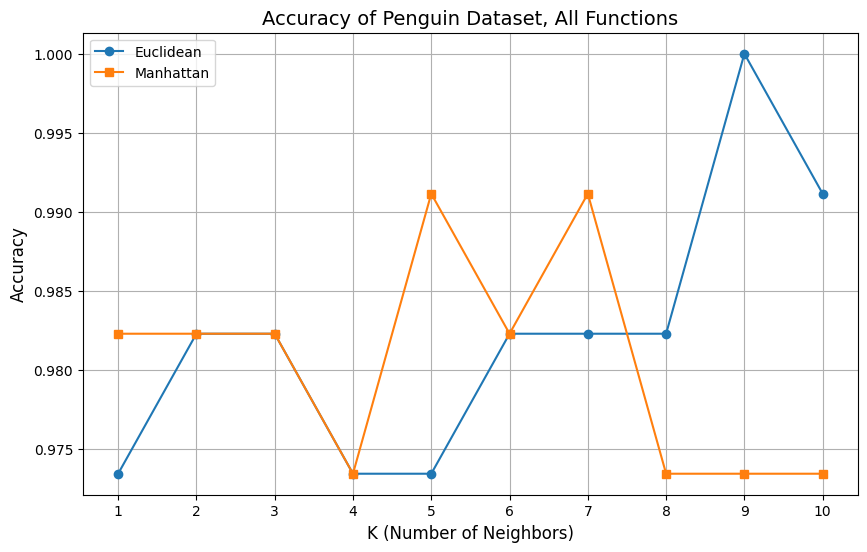

In [519]:
#             FINDING BEST K FOR PENGUIN, AND ACCURACY
#             NOTE: theoretically, manhattan and euclidean should have same result
#                   on standardized data (which penguin is)

knn_tracker_penguins = BestModel()


label_encoder = LabelEncoder()

# predictors
X = p_final_df.iloc[:, :-1].values
# response
y = p_final_df['species'].values
# one hot encoding response
y_encoded = label_encoder.fit_transform(y)

# split data into training, validating, testing
# 66% for training/validating, 34% for training
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.34, random_state=1234)
# 33% for training, 33% for validating (50% of 66% is 33%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=1234)

# Evaluate K for all the two numerica distances
k_values = range(1, 11)
distance_metrics = {"Euclidean": euclidean, "Manhattan": manhattan}
acc_results = {}
for metric_name in distance_metrics:
    acc_results[metric_name] = []

# Find best k based on evaluate acc function since this is not the binary classification task
print("=== KNN on Penguins ===")
for metric_name, metric_fn in distance_metrics.items():
    print(f"\nUsing {metric_name} distance:")
    for k in k_values:
        penguin_knn = KNN(K=k, dist_fn=metric_fn)
        penguin_knn.fit(X_train, y_train)
        val_acc = penguin_knn.evaluate_acc(X_val, y_val)
        acc_results[metric_name].append(val_acc)


        print(f"  K={k}, Validation Accuracy: {val_acc*100:.2f}%")


# Select best K per metric
best_k_val = {}
for metric_name, accuracies in acc_results.items():
    best_idx = np.argmax(accuracies)
    best_k_val[metric_name] = k_values[best_idx]

# Evaluate test accuracy
print("\n--- Best K & Test Accuracy on Penguins ---")
for name, best_k in best_k_val.items():
    print(f"Initializing KNN with distance function: {name} and K={best_k}")
    knn = KNN(K=best_k, dist_fn=distance_metrics[name])
    knn.fit(X_train_val, y_train_val)
    print("Training complete.")

    test_acc = knn.evaluate_acc(X_test, y_test)
    print(f"Distance: {name}, Best K={best_k}, Test Accuracy: {test_acc*100:.2f}%")

    # Update knn_tracker with the model, score, and parameters
    print("Updating knn tracker.")
    knn_tracker_penguins.update(
        model=knn,  # Assuming 'penguin_knn' is meant to be 'knn' based on context
        score=test_acc,
        params={"metric_name": name, "k": best_k}
    )
    print("Tracker updated.")


best_model, best_score, best_params = knn_tracker_penguins.get_best()

print("\n=== Best KNN Model for Penguins ===")
print(f"Best Test Score (Accuracy): {best_score:.4f}")
print(f"Best Parameters: {best_params}")




# get all k values
k_values = list(range(1,11))

# plotting accuracy of penguin dataset based on k
plt.figure(figsize=(10, 6))
plt.plot(k_values, list(acc_results["Euclidean"]), marker='o', label='Euclidean')
plt.plot(k_values, list(acc_results["Manhattan"]), marker='s', label='Manhattan')
plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy of Penguin Dataset, All Functions', fontsize=14)
plt.xticks(range(1, 11))
plt.grid()
plt.legend()
plt.show()

### Decision Tree for Penguin Dataset

In [520]:
X_all_features = np.column_stack([
    p_scaled_df
])

label_encoder_all = LabelEncoder()
y_all_features = label_encoder_all.fit_transform(penguin_df["species"])

In [521]:

dt_tracker_penguins = BestModel()


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_all_features, y_all_features, test_size=0.34, random_state=1234
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.5, random_state=1234
)

cost_functions = {
    "Misclassification": cost_misclassification,
    "Entropy": cost_entropy,
    "Gini Index": cost_gini_index,
}

max_depths = range(1, 21)

best_val_accuracy = 0.0
best_cost_fn_name = None
best_depth = None
best_tree_on_val = None


for cost_name, cost_fn in cost_functions.items():
    for depth in max_depths:
        print(f"Training Decision Tree with max_depth={depth} and cost_function={cost_name}")

        tree = DecisionTree(max_depth=depth, cost_fn=cost_fn, min_leaf_instances=1)
        tree.fit(X_train, y_train)

        val_accuracy = tree.evaluate_acc(X_val, y_val)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_cost_fn_name = cost_name
            best_depth = depth
            best_tree_on_val = tree

print("\n=== Best Hyperparameters from Validation ===")
print(f"Cost Function: {best_cost_fn_name}")
print(f"Max Depth: {best_depth}")
print(f"Validation Accuracy: {best_val_accuracy:.4f}")

final_tree = DecisionTree(
    max_depth=best_depth,
    cost_fn=cost_functions[best_cost_fn_name],
    min_leaf_instances=1
)
final_tree.fit(X_train_val, y_train_val)

test_accuracy = final_tree.evaluate_acc(X_test, y_test)

dt_tracker_penguins.update(
    model=final_tree,
    score=test_accuracy,
    params={"Cost Function": best_cost_fn_name, "Max Depth": best_depth}
    )


print("\n=== Final Evaluation on Test Set ===")
print(f"Test Accuracy: {test_accuracy:.4f}")

all_features_importance = final_tree.get_top_features(feature_names=p_num_features)

top_5_features = all_features_importance[:5]

print("\nTop 5 Features by Gini Reduction (Final Tree):")
for rank, (feature, reduction) in enumerate(all_features_importance, start=1):
    print(f"{rank}. {feature}: {reduction:.4f} Gini Reduction")

Training Decision Tree with max_depth=1 and cost_function=Misclassification
Validation Accuracy: 78.7611
Training Decision Tree with max_depth=2 and cost_function=Misclassification
Validation Accuracy: 92.9204
Training Decision Tree with max_depth=3 and cost_function=Misclassification
Validation Accuracy: 93.8053
Training Decision Tree with max_depth=4 and cost_function=Misclassification
Validation Accuracy: 92.9204
Training Decision Tree with max_depth=5 and cost_function=Misclassification
Validation Accuracy: 92.9204
Training Decision Tree with max_depth=6 and cost_function=Misclassification
Validation Accuracy: 92.9204
Training Decision Tree with max_depth=7 and cost_function=Misclassification
Validation Accuracy: 92.9204
Training Decision Tree with max_depth=8 and cost_function=Misclassification
Validation Accuracy: 92.9204
Training Decision Tree with max_depth=9 and cost_function=Misclassification
Validation Accuracy: 92.9204
Training Decision Tree with max_depth=10 and cost_funct

## Heart Dataset

### KNN Testing for Heart Dataset

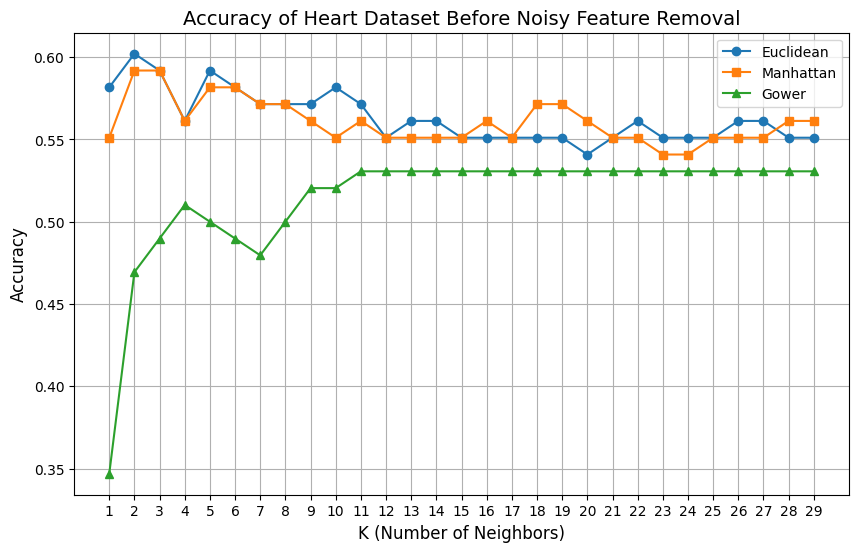

The maximum accuracy using Euclidean distance is 0.60204 at K = 2.


In [522]:
#             APPLYING KNN ON HEART DATASET

# initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
# fit encoder to categorical features and transform to one-hot encoded format
encoded_categorical = encoder.fit_transform(heart_df[h_cat_features])
# create dataframe of encoded categorical features
encoded_categorical_df = pd.DataFrame(
    encoded_categorical,
    columns=encoder.get_feature_names_out(h_cat_features),
    index=heart_df.index
    )

# concatenate one-hot encoded data with numerical data
combined_df = pd.concat([heart_df[h_num_features], encoded_categorical_df], axis=1)

# scale data
standardized_data = scaler.fit_transform(combined_df)
# create dataframe of scaled data
heart_final_df = pd.DataFrame(
    standardized_data,
    columns=combined_df.columns,
    index=combined_df.index
)

# predictors
X = heart_final_df.values
# response
y = heart_df['num'].values

# split data into training, validating, testing
# 66% for training/validating, 34% for training
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.34, random_state=1234)
# 33% for training, 33% for validating (50% of 66% is 33%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=1234)

# save accuracies from using euclidean, manhatten, gower as distance function
accuracy_euclidean = {}
accuracy_manhattan = {}
accuracy_gower = {}

# test k values from 1 to 29
for k in range(1, 30):
    # apply knn using euclidean as distance function
    knn = KNN(k, dist_fn=euclidean)
    knn.fit(X_train, y_train)
    accuracy_euclidean[k] = knn.evaluate_acc(X_val, y_val)

    # apply knn using manhattan as distance function
    knn = KNN(k, dist_fn=manhattan)
    knn.fit(X_train, y_train)
    accuracy_manhattan[k] = knn.evaluate_acc(X_val, y_val)

    # apply knn using gower as distance function
    knn = KNN(k, dist_fn=gower_distance)
    knn.fit(X_train, y_train)
    accuracy_gower[k] = knn.evaluate_acc(X_val, y_val)

# plotting Accuracies for Different Distance Metrics
k_values = list(accuracy_euclidean.keys())

# plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, list(accuracy_euclidean.values()), marker='o', label='Euclidean')
plt.plot(k_values, list(accuracy_manhattan.values()), marker='s', label='Manhattan')
plt.plot(k_values, list(accuracy_gower.values()), marker='^', label='Gower')

plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy of Heart Dataset Before Noisy Feature Removal', fontsize=14)
plt.xticks(k_values)
plt.grid()
plt.legend()
plt.show()

# find and print best k for euclidean
best_k_euclidean = max(accuracy_euclidean, key=accuracy_euclidean.get)
max_accuracy_euclidean = accuracy_euclidean[best_k_euclidean]
print(f"The maximum accuracy using Euclidean distance is {max_accuracy_euclidean:.5f} at K = {best_k_euclidean}.")

### Further KNN Testing on Numerical Features for Heart Dataset (sort with cross validation)

In [523]:
knn_tracker_heart = BestModel()

correlation_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

folds = 9
kf = KFold(n_splits=folds, shuffle=True, random_state=1234)

distance_metrics = {"Euclidean": euclidean, "Manhattan": manhattan}

k_values = range(1, 40)

validation_auroc_results = {metric: {t: [] for t in correlation_thresholds} for metric in distance_metrics}

test_auroc_results = {metric: [] for metric in distance_metrics}

for threshold in correlation_thresholds:
    print(f"\n=== Threshold: {threshold} ===")

    filtered_df = features_per_pearson_threshold[f"threshold_{threshold}"]
    X_filtered = filtered_df.to_numpy()
    y_filtered = hdf_target_pn

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_filtered, y_filtered, test_size=1 / folds, random_state=1234
    )

    best_k_val_numeric = {}
    for dist_name, dist_fn in distance_metrics.items():
        print(f"\nUsing {dist_name} distance:")
        best_k = None
        best_val_auroc = -1

        validation_auroc_results[dist_name][threshold] = []

        for k in k_values:
            knn = KNN(K=k, dist_fn=dist_fn)
            y_true, y_pred = cross_validate_knn(knn, X_train_val, y_train_val, kf)

            val_auroc = roc_auc_score(y_true, y_pred)
            validation_auroc_results[dist_name][threshold].append(val_auroc)

            print(f"  K={k}, Validation AUROC: {val_auroc:.4f}")

            if val_auroc > best_val_auroc:
                best_val_auroc = val_auroc
                best_k = k

        best_k_val_numeric[dist_name] = best_k

    print("\n=== Test AUROC Using Best K ===")

    for dist_name, best_k in best_k_val_numeric.items():
        knn = KNN(K=best_k, dist_fn=distance_metrics[dist_name])
        knn.fit(X_train_val, y_train_val)
        y_prob_test, _ = knn.predict(X_test)
        test_auroc = roc_auc_score(y_test, y_prob_test[:, 1])

        print(f"Distance={dist_name}, Best K={best_k}, Test AUROC={test_auroc:.4f}")

        test_auroc_results[dist_name].append((threshold, test_auroc))

        knn_tracker_heart.update(
            model=knn,
            score=test_auroc,
            params={"distance_metric": dist_name, "k": best_k, "threshold": threshold, "weighted": False}
        )

best_knn_heart, best_test_auroc_heart, best_params_heart = knn_tracker_heart.get_best()
print("\n=== Best KNN Model for Heart Numerical ===")
print(f"Best Model: {best_knn_heart}")
print(f"Best Test AUROC: {best_test_auroc_heart:.4f}")
print(f"Best Parameters: {best_params_heart}\n")


=== Threshold: 0.0 ===

Using Euclidean distance:
  K=1, Validation AUROC: 0.6808
  K=2, Validation AUROC: 0.7342
  K=3, Validation AUROC: 0.7597
  K=4, Validation AUROC: 0.7711
  K=5, Validation AUROC: 0.7772
  K=6, Validation AUROC: 0.7892
  K=7, Validation AUROC: 0.7939
  K=8, Validation AUROC: 0.7985
  K=9, Validation AUROC: 0.8107
  K=10, Validation AUROC: 0.8064
  K=11, Validation AUROC: 0.8082
  K=12, Validation AUROC: 0.8121
  K=13, Validation AUROC: 0.8122
  K=14, Validation AUROC: 0.8123
  K=15, Validation AUROC: 0.8121
  K=16, Validation AUROC: 0.8126
  K=17, Validation AUROC: 0.8131
  K=18, Validation AUROC: 0.8183
  K=19, Validation AUROC: 0.8207
  K=20, Validation AUROC: 0.8174
  K=21, Validation AUROC: 0.8180
  K=22, Validation AUROC: 0.8216
  K=23, Validation AUROC: 0.8216
  K=24, Validation AUROC: 0.8250
  K=25, Validation AUROC: 0.8238
  K=26, Validation AUROC: 0.8242
  K=27, Validation AUROC: 0.8233
  K=28, Validation AUROC: 0.8242
  K=29, Validation AUROC: 0.8229
 

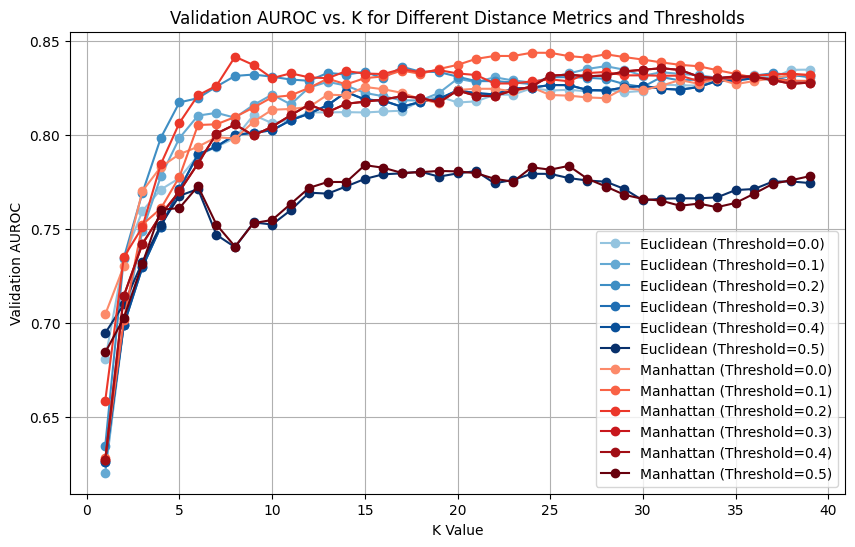

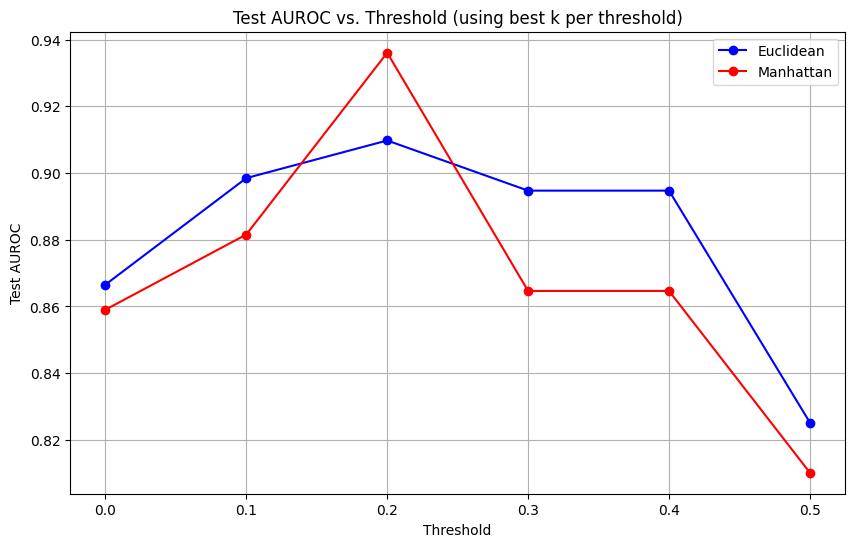

In [524]:
euclidean_colors = plt.cm.Blues(np.linspace(0.4, 1, len(correlation_thresholds)))  # blue shades
manhattan_colors = plt.cm.Reds(np.linspace(0.4, 1, len(correlation_thresholds)))  # red shades

plt.figure(figsize=(10, 6))

for dist_name, thresholds in validation_auroc_results.items():
    if dist_name == "Euclidean":
        colors = euclidean_colors
    else:  # if Manhattan
        colors = manhattan_colors

    for i, (threshold, auroc_values) in enumerate(thresholds.items()):
        plt.plot(k_values, auroc_values, marker='o', linestyle='-', color=colors[i],
                 label=f"{dist_name} (Threshold={threshold})")

plt.xlabel("K Value")
plt.ylabel("Validation AUROC")
plt.title("Validation AUROC vs. K for Different Distance Metrics and Thresholds")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))

for dist_name in test_auroc_results.keys():
    sorted_results = sorted(test_auroc_results[dist_name])  # Sort by threshold
    sorted_thresholds, sorted_aurocs = zip(*sorted_results)
    plt.plot(sorted_thresholds, sorted_aurocs, marker='o', linestyle='-',
             color="blue" if dist_name == "Euclidean" else "red",
             label=f"{dist_name}")

plt.xlabel("Threshold")
plt.ylabel("Test AUROC")
plt.title("Test AUROC vs. Threshold (using best k per threshold)")
plt.legend()
plt.grid(True)
plt.show()

### Further KNN Testing on Categorical Features for Heart Dataset (sort with cross validation)

In [525]:
knn_tracker_cat = BestModel()

fischer_thresholds = [0.001, 0.01, 0.05, 0.1, 1.0]

validation_auroc_results_cat = {t: [] for t in fischer_thresholds}
test_auroc_results_cat = []
test_auroc_results_by_k = []
k_values = range(1, 40)

for threshold in fischer_thresholds:
    print(f"\n=== Fischer Threshold = {threshold} ===")

    filtered_df = fischer_ds[f"critical value_{threshold}"]
    cat_encoded = filtered_df.to_numpy()

    X_train_val_cat, X_test_cat, y_train_val_cat, y_test_cat = train_test_split(
        cat_encoded, hdf_target_pn, test_size=1/folds, random_state=1234)

    auroc_results_cat = []
    test_aurocs_by_k = []

    for k in k_values:
        knn_cat = KNN(K=k, dist_fn=hamming)
        y_true, y_pred = cross_validate_knn(knn_cat, X_train_val_cat, y_train_val_cat, kf)
        val_auroc = roc_auc_score(y_true, y_pred)
        auroc_results_cat.append(val_auroc)

        print(f"  K={k}, Validation AUROC: {val_auroc:.4f}")

        knn_cat.fit(X_train_val_cat, y_train_val_cat)
        y_prob_test_cat, _ = knn_cat.predict(X_test_cat)
        test_auroc_cat = roc_auc_score(y_test_cat, y_prob_test_cat[:, 1])

        test_aurocs_by_k.append(test_auroc_cat)

    validation_auroc_results_cat[threshold] = auroc_results_cat
    test_auroc_results_by_k.append((k_values, test_aurocs_by_k))

    best_k_idx = np.argmax(auroc_results_cat)
    best_k_cat = k_values[best_k_idx]
    print(f"Best K for threshold {threshold}: {best_k_cat}")

    knn_cat = KNN(K=best_k_cat, dist_fn=hamming)
    knn_cat.fit(X_train_val_cat, y_train_val_cat)

    y_prob_test_cat, _ = knn_cat.predict(X_test_cat)
    test_auroc_cat = roc_auc_score(y_test_cat, y_prob_test_cat[:, 1])

    print(f"  Test AUROC with Hamming Distance (threshold={threshold}): {test_auroc_cat:.4f}")

    test_auroc_results_cat.append((threshold, test_auroc_cat, best_k_cat))

    knn_tracker_heart.update(
        model=knn_cat,
        score=test_auroc_cat,
        params={"threshold": threshold, "k": best_k_cat, "distance_metric": "Hamming", "weighted": False}
    )

    knn_tracker_cat.update(
        model=knn_cat,
        score=test_auroc_cat,
        params={"threshold": threshold, "k": best_k_cat, "distance_metric": "Hamming", "weighted": False}
    )

best_knn_heart, best_test_auroc_heart, best_params_heart = knn_tracker_cat.get_best()
print("\n=== Best KNN Model for Heart Categorical ===")
print(f"Best Model: {best_knn_heart}")
print(f"Best Test AUROC: {best_test_auroc_heart:.4f}")
print(f"Best Parameters: {best_params_heart}")


=== Fischer Threshold = 0.001 ===
  K=1, Validation AUROC: 0.7196
  K=2, Validation AUROC: 0.7825
  K=3, Validation AUROC: 0.8109
  K=4, Validation AUROC: 0.8302
  K=5, Validation AUROC: 0.8350
  K=6, Validation AUROC: 0.8437
  K=7, Validation AUROC: 0.8494
  K=8, Validation AUROC: 0.8547
  K=9, Validation AUROC: 0.8510
  K=10, Validation AUROC: 0.8529
  K=11, Validation AUROC: 0.8519
  K=12, Validation AUROC: 0.8520
  K=13, Validation AUROC: 0.8475
  K=14, Validation AUROC: 0.8538
  K=15, Validation AUROC: 0.8580
  K=16, Validation AUROC: 0.8608
  K=17, Validation AUROC: 0.8604
  K=18, Validation AUROC: 0.8597
  K=19, Validation AUROC: 0.8599
  K=20, Validation AUROC: 0.8629
  K=21, Validation AUROC: 0.8637
  K=22, Validation AUROC: 0.8670
  K=23, Validation AUROC: 0.8661
  K=24, Validation AUROC: 0.8675
  K=25, Validation AUROC: 0.8687
  K=26, Validation AUROC: 0.8695
  K=27, Validation AUROC: 0.8698
  K=28, Validation AUROC: 0.8686
  K=29, Validation AUROC: 0.8685
  K=30, Validatio

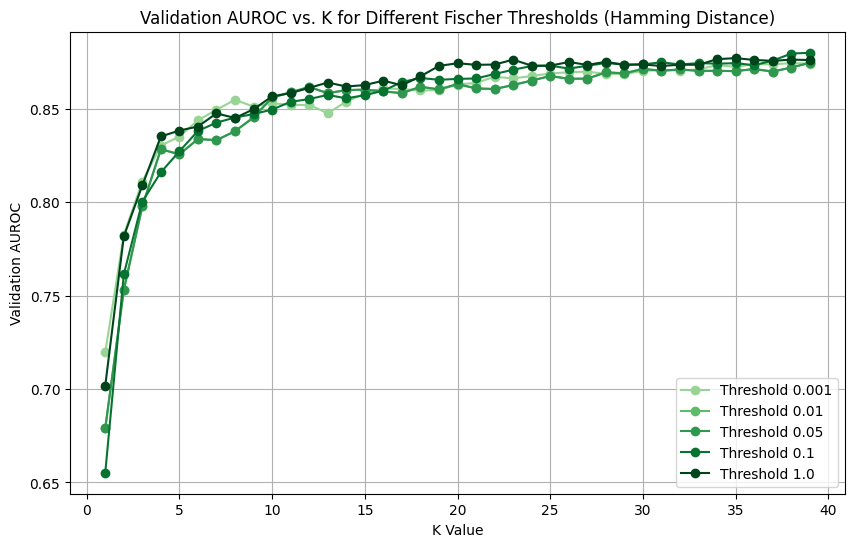

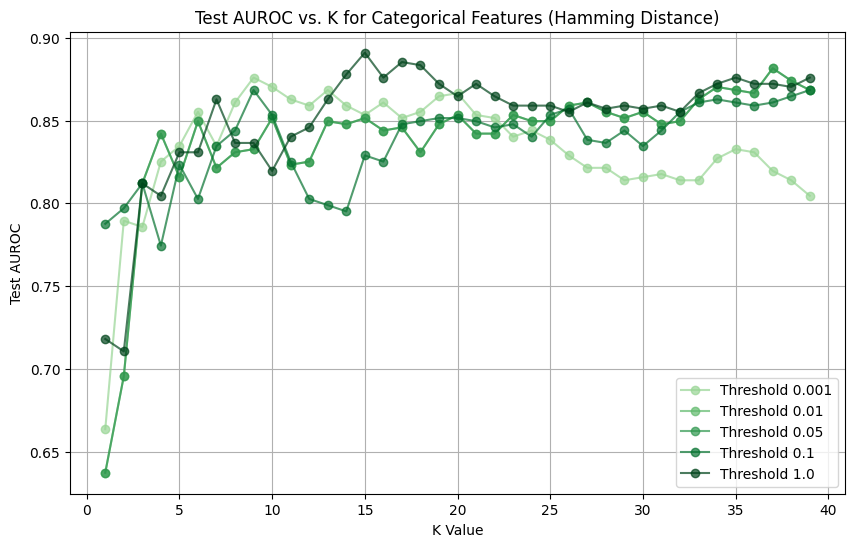

In [526]:
plt.figure(figsize=(10, 6))

colors = plt.cm.Greens(np.linspace(0.4, 1, len(fischer_thresholds)))

for i, (threshold, auroc_values) in enumerate(validation_auroc_results_cat.items()):
    plt.plot(k_values, auroc_values, marker='o', linestyle='-', color=colors[i],
             label=f"Threshold {threshold}")

plt.xlabel("K Value")
plt.ylabel("Validation AUROC")
plt.title("Validation AUROC vs. K for Different Fischer Thresholds (Hamming Distance)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

for i, (k_vals, test_aurocs) in enumerate(test_auroc_results_by_k):
    plt.plot(k_vals, test_aurocs, marker='o', linestyle='-', color=colors[i], alpha=0.7,
             label=f"Threshold {fischer_thresholds[i]}")

plt.xlabel("K Value")
plt.ylabel("Test AUROC")
plt.title("Test AUROC vs. K for Categorical Features (Hamming Distance)")
plt.legend()
plt.grid(True)
plt.show()


### Further KNN Testing on Entire Heart Dataset (sort with cross validation)

In [527]:
knn_tracker_all = BestModel()

k_values = range(1, 40)

for subset_name, combined_df in combined_dict.items():
    print(f"\n=== Processing Subset: {subset_name} ===")

    X = combined_df.to_numpy()

    y = hdf_target_pn[combined_df.index]


    X_train_val, X_evaluation, y_train_val, y_evaluation = train_test_split(
        X, y, test_size=1 / folds, random_state=1234
    )

    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
    assert len(y) == X.shape[0], "Mismatch in the number of rows between X and y."

    auroc_results = []
    for k in k_values:
        knn_model = KNN(K=k, dist_fn=euclidean, weighted=False)

        y_true, y_pred = cross_validate_knn(knn_model, X_train_val, y_train_val, kf)

        val_auroc = roc_auc_score(y_true, y_pred)
        auroc_results.append(val_auroc)

        print(f"  K={k}, Validation AUROC: {val_auroc:.4f}")

    best_k_idx = np.argmax(auroc_results)
    best_k = k_values[best_k_idx]
    print(f"Best K for '{subset_name}': {best_k}")

    knn_best = KNN(K=best_k, dist_fn=euclidean, weighted=False)
    knn_best.fit(X_train_val, y_train_val)

    y_prob_evaluation, _ = knn_best.predict(X_evaluation)
    test_auroc = roc_auc_score(y_evaluation, y_prob_evaluation[:, 1])

    print(f"  Test AUROC for '{subset_name}' with K={best_k}: {test_auroc:.4f}")

    knn_tracker_heart.update(
        model=knn_best,
        score=test_auroc,
        params={"subset_name": subset_name, "k": best_k, "weighted": False}
    )

    knn_tracker_all.update(
        model=knn_best,
        score=test_auroc,
        params={"subset_name": subset_name, "k": best_k, "weighted": False}
    )

best_knn_heart, best_test_heart, best_params_heart = knn_tracker_heart.get_best()

print("\n=== Best KNN Model Overall ===")
print(f"Best Model: {best_knn_heart}")
print(f"Best Test AUROC: {best_test_heart:.4f}")
print(f"Best Parameters: {best_params_heart}")


=== Processing Subset: corr_0.0_fisher_0.001 ===
Shape of X: (297, 17), Shape of y: (297,)
  K=1, Validation AUROC: 0.7463
  K=2, Validation AUROC: 0.8183
  K=3, Validation AUROC: 0.8600
  K=4, Validation AUROC: 0.8728
  K=5, Validation AUROC: 0.8764
  K=6, Validation AUROC: 0.8827
  K=7, Validation AUROC: 0.8803
  K=8, Validation AUROC: 0.8812
  K=9, Validation AUROC: 0.8812
  K=10, Validation AUROC: 0.8843
  K=11, Validation AUROC: 0.8903
  K=12, Validation AUROC: 0.8975
  K=13, Validation AUROC: 0.8973
  K=14, Validation AUROC: 0.8957
  K=15, Validation AUROC: 0.8981
  K=16, Validation AUROC: 0.8939
  K=17, Validation AUROC: 0.8933
  K=18, Validation AUROC: 0.8916
  K=19, Validation AUROC: 0.8905
  K=20, Validation AUROC: 0.8928
  K=21, Validation AUROC: 0.8935
  K=22, Validation AUROC: 0.8947
  K=23, Validation AUROC: 0.8956
  K=24, Validation AUROC: 0.8970
  K=25, Validation AUROC: 0.8958
  K=26, Validation AUROC: 0.8942
  K=27, Validation AUROC: 0.8949
  K=28, Validation AUROC: 

### Further KNN Testing on Entire Heart Dataset Weighted (sort with cross validation)

In [528]:
k_values = range(1, 40)

for subset_name, combined_df in combined_dict.items():
    print(f"\n=== Processing Subset: {subset_name} ===")

    X = combined_df.to_numpy()

    y = hdf_target_pn

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=1 / folds, random_state=1234
    )

    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
    assert len(y) == X.shape[0], "Mismatch in the number of rows between X and y."

    auroc_results = []
    for k in k_values:
        knn_model = KNN(K=k, dist_fn=euclidean, weighted=True)

        y_true, y_pred = cross_validate_knn(knn_model, X_train_val, y_train_val, kf)

        val_auroc = roc_auc_score(y_true, y_pred)
        auroc_results.append(val_auroc)

        print(f"  K={k}, Validation AUROC: {val_auroc:.4f}")

    best_k_idx = np.argmax(auroc_results)
    best_k = k_values[best_k_idx]
    print(f"Best K for '{subset_name}': {best_k}")

    knn_best = KNN(K=best_k, dist_fn=euclidean, weighted=True)
    knn_best.fit(X_train_val, y_train_val)

    y_prob_evaluation, _ = knn_best.predict(X_test)
    test_auroc = roc_auc_score(y_test, y_prob_evaluation[:, 1])

    print(f"  Test AUROC for '{subset_name}' with K={best_k}: {test_auroc:.4f}")

    knn_tracker_heart.update(
        model=knn_best,
        score=test_auroc,
        params={"subset_name": subset_name, "k": best_k, "weighted": True}
    )

best_knn_heart, best_test_heart, best_params_heart = knn_tracker_heart.get_best()

print("\n=== Best KNN Model Overall ===")
print(f"Best Model: {best_knn_heart}")
print(f"Best Test AUROC: {best_test_heart:.4f}")
print(f"Best Parameters: {best_params_heart}")


=== Processing Subset: corr_0.0_fisher_0.001 ===
Shape of X: (297, 17), Shape of y: (297,)
  K=1, Validation AUROC: 0.7419
  K=2, Validation AUROC: 0.8172
  K=3, Validation AUROC: 0.8516
  K=4, Validation AUROC: 0.8615
  K=5, Validation AUROC: 0.8621
  K=6, Validation AUROC: 0.8677
  K=7, Validation AUROC: 0.8661
  K=8, Validation AUROC: 0.8700
  K=9, Validation AUROC: 0.8699
  K=10, Validation AUROC: 0.8722
  K=11, Validation AUROC: 0.8748
  K=12, Validation AUROC: 0.8809
  K=13, Validation AUROC: 0.8820
  K=14, Validation AUROC: 0.8827
  K=15, Validation AUROC: 0.8846
  K=16, Validation AUROC: 0.8809
  K=17, Validation AUROC: 0.8829
  K=18, Validation AUROC: 0.8813
  K=19, Validation AUROC: 0.8809
  K=20, Validation AUROC: 0.8831
  K=21, Validation AUROC: 0.8827
  K=22, Validation AUROC: 0.8833
  K=23, Validation AUROC: 0.8840
  K=24, Validation AUROC: 0.8851
  K=25, Validation AUROC: 0.8843
  K=26, Validation AUROC: 0.8838
  K=27, Validation AUROC: 0.8850
  K=28, Validation AUROC: 

### Further KNN Testing on Numerical Features for Heart Dataset Weighted (sort with cross validation)

In [529]:
correlation_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

folds = 9
kf = KFold(n_splits=folds, shuffle=True, random_state=1234)

distance_metrics = {"Euclidean": euclidean, "Manhattan": manhattan}

k_values = range(1, 40)

validation_auroc_results = {metric: {t: [] for t in correlation_thresholds} for metric in distance_metrics}

test_auroc_results = {metric: [] for metric in distance_metrics}

for threshold in correlation_thresholds:
    print(f"\n=== Threshold: {threshold} ===")

    filtered_df = features_per_pearson_threshold[f"threshold_{threshold}"]
    X_filtered = filtered_df.to_numpy()
    y_filtered = hdf_target_pn

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_filtered, y_filtered, test_size=1 / folds, random_state=1234
    )

    best_k_val_numeric = {}
    for dist_name, dist_fn in distance_metrics.items():
        print(f"\nUsing {dist_name} distance:")
        best_k = None
        best_val_auroc = -1

        validation_auroc_results[dist_name][threshold] = []

        for k in k_values:
            knn = KNN(K=k, dist_fn=dist_fn, weighted = True)
            y_true, y_pred = cross_validate_knn(knn, X_train_val, y_train_val, kf)

            val_auroc = roc_auc_score(y_true, y_pred)
            validation_auroc_results[dist_name][threshold].append(val_auroc)

            print(f"  K={k}, Validation AUROC: {val_auroc:.4f}")

            if val_auroc > best_val_auroc:
                best_val_auroc = val_auroc
                best_k = k

        best_k_val_numeric[dist_name] = best_k

    print("\n=== Test AUROC Using Best K ===")

    for dist_name, best_k in best_k_val_numeric.items():
        knn = KNN(K=best_k, dist_fn=distance_metrics[dist_name])
        knn.fit(X_train_val, y_train_val)
        y_prob_test, _ = knn.predict(X_test)
        test_auroc = roc_auc_score(y_test, y_prob_test[:, 1])

        print(f"Distance={dist_name}, Best K={best_k}, Test AUROC={test_auroc:.4f}")

        test_auroc_results[dist_name].append((threshold, test_auroc))

        knn_tracker_heart.update(
            model=knn,
            score=test_auroc,
            params={"distance_metric": dist_name, "k": best_k, "threshold": threshold, "weighted": True}
        )

best_knn_heart, best_test_auroc_heart, best_params_heart = knn_tracker_heart.get_best()
print("\n=== Best KNN Model for Heart Overall ===")
print(f"Best Model: {best_knn_heart}")
print(f"Best Test AUROC: {best_test_auroc_heart:.4f}")
print(f"Best Parameters: {best_params_heart}\n")


=== Threshold: 0.0 ===

Using Euclidean distance:
  K=1, Validation AUROC: 0.6518
  K=2, Validation AUROC: 0.6895
  K=3, Validation AUROC: 0.7146
  K=4, Validation AUROC: 0.7249
  K=5, Validation AUROC: 0.7284
  K=6, Validation AUROC: 0.7389
  K=7, Validation AUROC: 0.7448
  K=8, Validation AUROC: 0.7534
  K=9, Validation AUROC: 0.7654
  K=10, Validation AUROC: 0.7629
  K=11, Validation AUROC: 0.7682
  K=12, Validation AUROC: 0.7745
  K=13, Validation AUROC: 0.7751
  K=14, Validation AUROC: 0.7756
  K=15, Validation AUROC: 0.7776
  K=16, Validation AUROC: 0.7758
  K=17, Validation AUROC: 0.7761
  K=18, Validation AUROC: 0.7822
  K=19, Validation AUROC: 0.7868
  K=20, Validation AUROC: 0.7815
  K=21, Validation AUROC: 0.7822
  K=22, Validation AUROC: 0.7860
  K=23, Validation AUROC: 0.7866
  K=24, Validation AUROC: 0.7931
  K=25, Validation AUROC: 0.7918
  K=26, Validation AUROC: 0.7920
  K=27, Validation AUROC: 0.7912
  K=28, Validation AUROC: 0.7934
  K=29, Validation AUROC: 0.7917
 

### Further KNN Testing on Categorical Features for Heart Dataset Weighted (sort with cross validation)

In [530]:
fischer_thresholds = [0.001, 0.01, 0.05, 0.1, 1.0]

validation_auroc_results_cat = {t: [] for t in fischer_thresholds}
test_auroc_results_cat = []
k_values = range(1, 40)
for threshold in fischer_thresholds:
    print(f"\n=== Fischer Threshold = {threshold} ===")

    filtered_df = fischer_ds[f"critical value_{threshold}"]
    cat_encoded = filtered_df.to_numpy()

    X_train_val_cat, X_test_cat, y_train_val_cat, y_test_cat = train_test_split(
        cat_encoded, hdf_target_pn, test_size=1/folds, random_state=1234
    )

    auroc_results_cat = []
    for k in k_values:
        knn_cat = KNN(K=k, dist_fn=hamming)
        y_true, y_pred = cross_validate_knn(knn_cat, X_train_val_cat, y_train_val_cat, kf)
        val_auroc = roc_auc_score(y_true, y_pred)
        auroc_results_cat.append(val_auroc)

        print(f"  K={k}, Validation AUROC: {val_auroc:.4f}")

    validation_auroc_results_cat[threshold] = auroc_results_cat

    best_k_idx = np.argmax(auroc_results_cat)
    best_k_cat = k_values[best_k_idx]
    print(f"Best K for threshold {threshold}: {best_k_cat}")

    knn_cat = KNN(K=best_k_cat, dist_fn=hamming, weighted = True)
    knn_cat.fit(X_train_val_cat, y_train_val_cat)

    y_prob_test_cat, _ = knn_cat.predict(X_test_cat)
    test_auroc_cat = roc_auc_score(y_test_cat, y_prob_test_cat[:, 1])

    print(f"  Test AUROC with Hamming Distance (threshold={threshold}): {test_auroc_cat:.4f}")

    test_auroc_results_cat.append((threshold, test_auroc_cat, best_k_cat))

    knn_tracker_heart.update(
        model=knn_cat,
        score=test_auroc_cat,
        params={"threshold": threshold, "k": best_k_cat, "distance_metric": "Hamming", "weighted": True}
    )

best_knn_heart, best_test_auroc_heart, best_params_heart = knn_tracker_heart.get_best()
print("\n=== Best KNN Model for Heart Overall ===")
print(f"Best Model: {best_knn_heart}")
print(f"Best Test AUROC: {best_test_auroc_heart:.4f}")
print(f"Best Parameters: {best_params_heart}")


=== Fischer Threshold = 0.001 ===
  K=1, Validation AUROC: 0.7196
  K=2, Validation AUROC: 0.7825
  K=3, Validation AUROC: 0.8109
  K=4, Validation AUROC: 0.8302
  K=5, Validation AUROC: 0.8350
  K=6, Validation AUROC: 0.8437
  K=7, Validation AUROC: 0.8494
  K=8, Validation AUROC: 0.8547
  K=9, Validation AUROC: 0.8510
  K=10, Validation AUROC: 0.8529
  K=11, Validation AUROC: 0.8519
  K=12, Validation AUROC: 0.8520
  K=13, Validation AUROC: 0.8475
  K=14, Validation AUROC: 0.8538
  K=15, Validation AUROC: 0.8580
  K=16, Validation AUROC: 0.8608
  K=17, Validation AUROC: 0.8604
  K=18, Validation AUROC: 0.8597
  K=19, Validation AUROC: 0.8599
  K=20, Validation AUROC: 0.8629
  K=21, Validation AUROC: 0.8637
  K=22, Validation AUROC: 0.8670
  K=23, Validation AUROC: 0.8661
  K=24, Validation AUROC: 0.8675
  K=25, Validation AUROC: 0.8687
  K=26, Validation AUROC: 0.8695
  K=27, Validation AUROC: 0.8698
  K=28, Validation AUROC: 0.8686
  K=29, Validation AUROC: 0.8685
  K=30, Validatio

### Decision Tree for Heart Dataset

In [531]:
dt_tracker_heart = BestModel()

X_heart = np.hstack([h_final_df[h_num_features], h_final_df[h_cat_features].to_numpy()])

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_heart, hdf_target_pn, test_size=0.34, random_state=1234
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.5, random_state=1234
)

cost_functions = {
    "Misclassification": cost_misclassification,
    "Entropy": cost_entropy,
    "Gini Index": cost_gini_index,
}

max_depths = range(1, 21)

for cost_name, cost_fn in cost_functions.items():
    print(f"=== Cost Function: {cost_name} ===")

    best_val_accuracy_for_cost = -1
    best_dt_for_cost = None
    best_depth_for_cost = None

    for depth in max_depths:
        print(f"  Training Decision Tree with max_depth={depth}")

        tree = DecisionTree(max_depth=depth, cost_fn=cost_fn, min_leaf_instances=1)
        tree.fit(X_train, y_train)

        y_pred = tree.predict(X_val)
        val_accuracy = roc_auc_score(y_val, y_pred[:, 1])
        print(f"    Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy_for_cost:
            best_val_accuracy_for_cost = val_accuracy
            best_dt_for_cost = tree
            best_depth_for_cost = depth

    test_accuracy = best_dt_for_cost.evaluate_acc(X_test, y_test)
    print(f"  -> Best Depth for {cost_name}: {best_depth_for_cost}")
    print(f"  -> Test Accuracy for Best {cost_name} Model: {test_accuracy:.4f}\n")

    dt_tracker_heart.update(
        model=best_dt_for_cost,
        score=test_accuracy,
        params={"Cost Function": cost_name, "Max Depth": best_depth_for_cost},
    )

best_dt_heart, best_test_accuracy_heart_dt, best_params_heart_dt = dt_tracker_heart.get_best()

print("\n=== Best Decision Tree Model for Heart ===")
print(f"Best Model: {best_dt_heart}")
print(f"Best Test Accuracy: {best_test_accuracy_heart_dt:.4f}")
print(f"Best Parameters: {best_params_heart_dt}")

heart_features = h_num_features + h_cat_features
top_features_heart_dt = best_dt_heart.get_top_features(feature_names=heart_features)

print("\nTop Features by Gini Reduction (Decision Tree for Heart):")
for rank, (feature, reduction) in enumerate(top_features_heart_dt[:5], start=1):
    print(f"{rank}. {feature}: {reduction:.4f} Gini Reduction")

top_5_features = [feature for feature, _ in top_features_heart_dt[:5]]
top_5_feature_indices = [heart_features.index(f) for f in top_5_features]
X_train_top5 = X_train[:, top_5_feature_indices]
X_val_top5 = X_val[:, top_5_feature_indices]
X_test_top5 = X_test[:, top_5_feature_indices]

dt_tracker_top5 = BestModel()

for cost_name, cost_fn in cost_functions.items():
    print(f"=== Cost Function (Top 5): {cost_name} ===")

    best_val_accuracy_for_cost = -1
    best_dt_for_cost = None
    best_depth_for_cost = None

    for depth in max_depths:
        print(f"  Training Decision Tree with max_depth={depth}, using top 5 features")

        tree = DecisionTree(max_depth=depth, cost_fn=cost_fn, min_leaf_instances=1)
        tree.fit(X_train_top5, y_train)

        y_pred = tree.predict(X_val_top5)
        val_accuracy = roc_auc_score(y_val, y_pred[:, 1])

        print(f"    Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy_for_cost:
            best_val_accuracy_for_cost = val_accuracy
            best_dt_for_cost = tree
            best_depth_for_cost = depth

    test_accuracy = best_dt_for_cost.evaluate_acc(X_test_top5, y_test)
    print(f"  -> Best Depth for {cost_name} (Top 5): {best_depth_for_cost}")
    print(f"  -> Test Accuracy (Top 5): {test_accuracy:.4f}\n")

    dt_tracker_top5.update(
        model=best_dt_for_cost,
        score=test_accuracy,
        params={"Cost Function": cost_name, "Max Depth": best_depth_for_cost}
        )

best_dt_top5, best_test_accuracy_top5, best_params_top5 = dt_tracker_top5.get_best()

print("\n=== Best Decision Tree Model for Top 5 Features ===")
print(f"Best Model: {best_dt_top5}")
print(f"Best Test Accuracy: {best_test_accuracy_top5:.4f}")
print(f"Best Parameters: {best_params_top5}")

=== Cost Function: Misclassification ===
  Training Decision Tree with max_depth=1
    Validation Accuracy: 0.8240
  Training Decision Tree with max_depth=2
    Validation Accuracy: 0.8267
  Training Decision Tree with max_depth=3
    Validation Accuracy: 0.7918
  Training Decision Tree with max_depth=4
    Validation Accuracy: 0.7722
  Training Decision Tree with max_depth=5
    Validation Accuracy: 0.8211
  Training Decision Tree with max_depth=6
    Validation Accuracy: 0.8154
  Training Decision Tree with max_depth=7
    Validation Accuracy: 0.8236
  Training Decision Tree with max_depth=8
    Validation Accuracy: 0.8066
  Training Decision Tree with max_depth=9
    Validation Accuracy: 0.7584
  Training Decision Tree with max_depth=10
    Validation Accuracy: 0.7525
  Training Decision Tree with max_depth=11
    Validation Accuracy: 0.7788
  Training Decision Tree with max_depth=12
    Validation Accuracy: 0.7709
  Training Decision Tree with max_depth=13
    Validation Accuracy: 

### ROC Curves and AUC

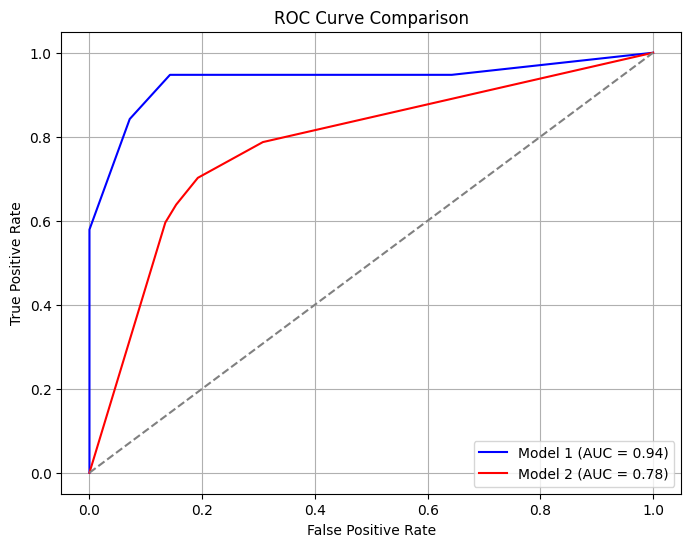

In [532]:
best_knn_heart, best_test_auroc_heart, best_params_heart = knn_tracker_heart.get_best()
best_dt_heart, best_test_accuracy_heart, best_params_heart_dt = dt_tracker_heart.get_best()

distance_metrics = {"Euclidean": euclidean, "Manhattan": manhattan}

cost_functions = {
    "Misclassification": cost_misclassification,
    "Entropy": cost_entropy,
    "Gini Index": cost_gini_index,
}


X_best_knn = features_per_pearson_threshold[f"threshold_{best_params_heart['threshold']}"].to_numpy()
X_train_val_knn, X_test_knn, y_train_val_knn, y_test_knn = train_test_split(
    X_best_knn, hdf_target_pn, test_size=1/9, random_state=1234
)

knn = KNN(K=best_params_heart['k'], dist_fn=distance_metrics.get(best_params_heart['distance_metric']))
knn.fit(X_train_val_knn, y_train_val_knn)
y_prob_test_knn, _ = knn.predict(X_test_knn)


X_heart = np.hstack([h_final_df[h_num_features], h_final_df[h_cat_features].to_numpy()])

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_heart, hdf_target_pn, test_size=0.33, random_state=1234
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.52, random_state=1234
)

tree = DecisionTree(max_depth=best_params_heart_dt['Max Depth'], cost_fn=cost_functions.get(best_params_heart_dt['Cost Function']), min_leaf_instances=1)
tree.fit(X_train, y_train)

y_prob_test_dt = tree.predict(X_test)

fpr1, tpr1, _ = roc_curve(y_test_knn, y_prob_test_knn[:, 1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_prob_test_dt[:, 1])
roc_auc2 = auc(fpr2, tpr2)

plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'Model 1 (AUC = {roc_auc1:.2f})', color='blue')
plt.plot(fpr2, tpr2, label=f'Model 2 (AUC = {roc_auc2:.2f})', color='red')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()